In [1]:
#%% import packages, methods and set environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd, path

# local classes and methods
from pybefit.agents.torch import VISAT  # value iteration agent for SAT
from pybefit.inference.pyro import NormalGammaDiscreteDepth  # A hierarchical parametric model with discrete variables
from utils import errorplot
from utils import load_and_format_SAT_data

# set data directory as relative path from this files directory
reppath = getcwd()
datadir = path.join(reppath,"data")

sns.set(context='talk', style='white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

In [47]:
#%% load and format behavioural data
path_hc  =  path.join(datadir,"HC","SAT","Experiment")
path_aud =  path.join(datadir,"AUD","SAT","Experiment")

stimuli_hc,  conditions_hc,  responses_hc,  mask_hc,  rts_hc,  ids_hc,  scores_hc,  sbj_df_hc  = load_and_format_SAT_data(path_hc)
stimuli_aud, conditions_aud, responses_aud, mask_aud, rts_aud, ids_aud, scores_aud, sbj_df_aud = load_and_format_SAT_data(path_aud)

In [48]:
#%% exclude datasets with close to random responses and reload
ids_to_exclude_hc  =  sbj_df_hc.loc[sbj_df_hc.total_points  <= 500, 'IDs'].values
ids_to_exclude_aud = sbj_df_aud.loc[sbj_df_aud.total_points <= 500, 'IDs'].values
print(str(len(ids_to_exclude_hc)) + " hc ids excluded: " + str(ids_to_exclude_hc))
print(str(len(ids_to_exclude_aud)) + " aud ids excluded: " + str(ids_to_exclude_aud))

stimuli_hc,  conditions_hc,  responses_hc,  mask_hc,  rts_hc,  ids_hc,  scores_hc,  sbj_df_hc  = load_and_format_SAT_data(path_hc,  ids_to_exclude_hc)
stimuli_aud, conditions_aud, responses_aud, mask_aud, rts_aud, ids_aud, scores_aud, sbj_df_aud = load_and_format_SAT_data(path_aud, ids_to_exclude_aud)

3 hc ids excluded: ['00022' '00023' '00019']
0 aud ids excluded: []


In [4]:
#%% Define probabilistic inference methods
def variational_inference(stimuli, mask, responses):
    max_depth = 3
    mini_blocks, max_trials, runs = responses.shape
    
    confs = stimuli['configs']
    
    # define agent
    agent = VISAT(
        confs,
        runs=runs,
        mini_blocks=mini_blocks,
        trials=max_trials,
        planning_depth=max_depth
    )

    # load inference module and start model fitting
    infer = NormalGammaDiscreteDepth(agent, stimuli, responses, mask)
    infer.infer_posterior(iter_steps=2000, num_particles=10, optim_kwargs={'lr': 0.01})
    
    return infer


# sample from posterior
def format_posterior_samples(infer):
    labels = [r'$\beta$', r'$\theta$', r'$\alpha$']
    _, pars_df, mg_df, sg_df = infer.sample_posterior(labels)

    return pars_df.melt(id_vars=['subject'], var_name='parameter')

In [5]:
#%% Variational inference HC
# passed responses should have the shape n_blocks, n_trials, n_subjects
infer_hc = variational_inference(stimuli_hc, mask_hc, responses_hc.permute(1, 2, 0))
pars_df_hc = format_posterior_samples(infer_hc)

max_trials = conditions_hc[-1, :, 0]
order_hc = (max_trials == 3) + 1
pars_df_hc['order'] = order_hc[pars_df_hc.subject - 1]

n_samples = 100
post_marg_hc = infer_hc.sample_posterior_marginal(n_samples=n_samples)
pars_df_hc['ID'] = np.array(ids_hc)[pars_df_hc.subject.values - 1]

Sample posterior discrete marginal: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


In [6]:
#%% Variational inference AUD
# passed responses should have the shape n_blocks, n_trials, n_subjects
infer_aud = variational_inference(stimuli_aud, mask_aud, responses_aud.permute(1, 2, 0))
pars_df_aud = format_posterior_samples(infer_aud)

max_trials = conditions_aud[-1, :, 0]
order_aud = (max_trials == 3) + 1
pars_df_aud['order'] = order_aud[pars_df_aud.subject - 1]

n_samples = 100
post_marg_aud = infer_aud.sample_posterior_marginal(n_samples=n_samples)
pars_df_aud['ID'] = np.array(ids_aud)[pars_df_aud.subject.values - 1]

Sample posterior discrete marginal: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


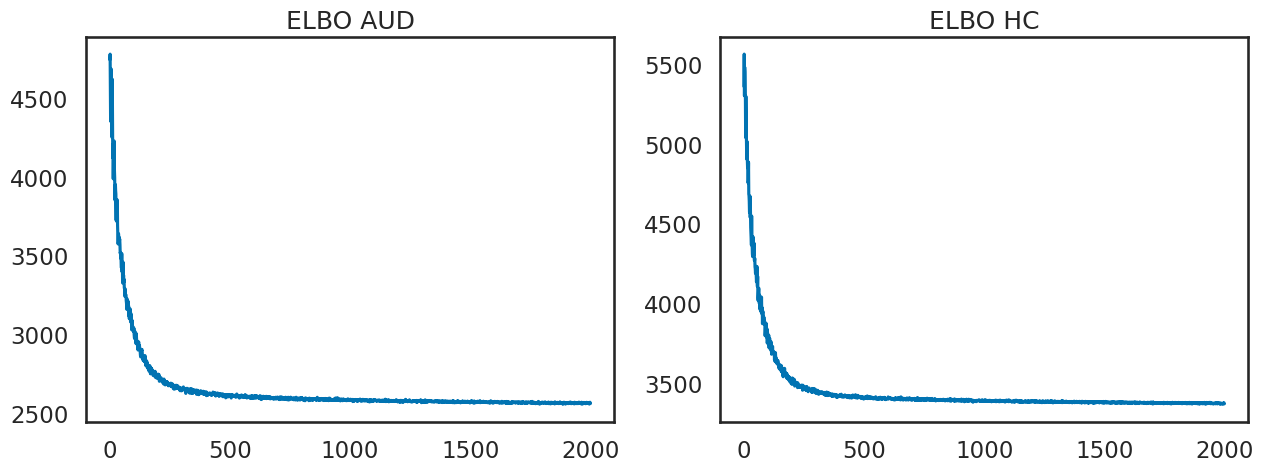

In [29]:
#%% plot convergence of ELBO bound (approximate value of the negative marginal log likelihood)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
loss = [infer_aud.loss, infer_hc.loss]
for i in range(2):
    axes[i].plot(loss[i])

axes[0].set_title('ELBO AUD');
axes[1].set_title('ELBO HC');

# save the figure
fig.savefig('elbo.pdf', dpi=300)

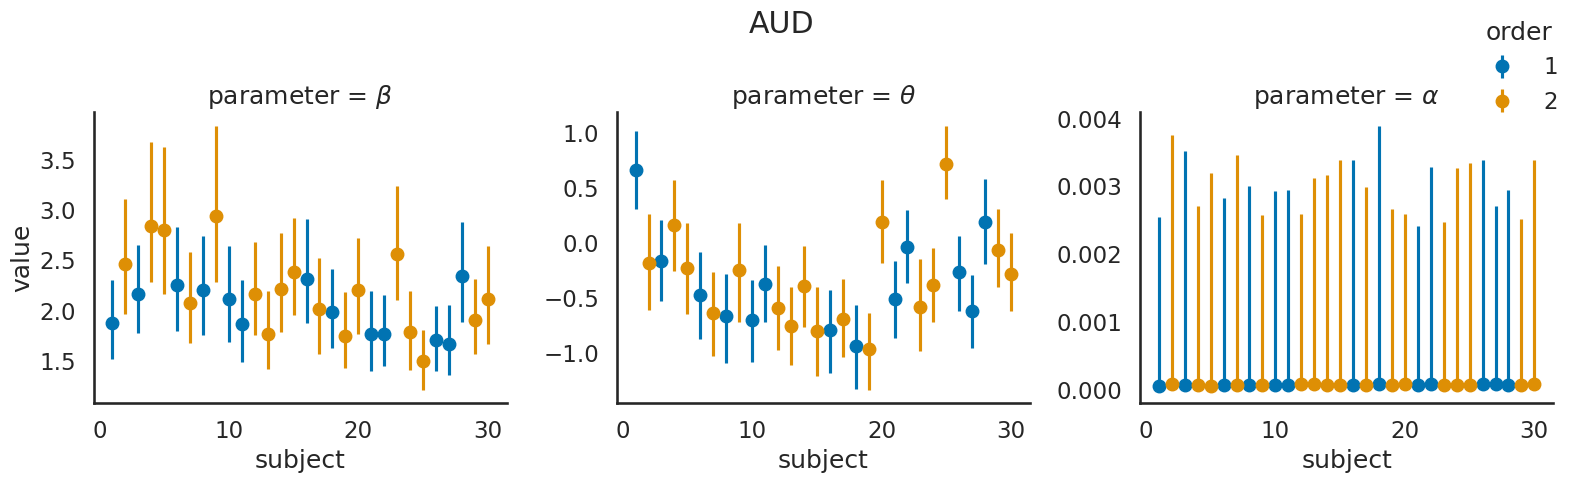

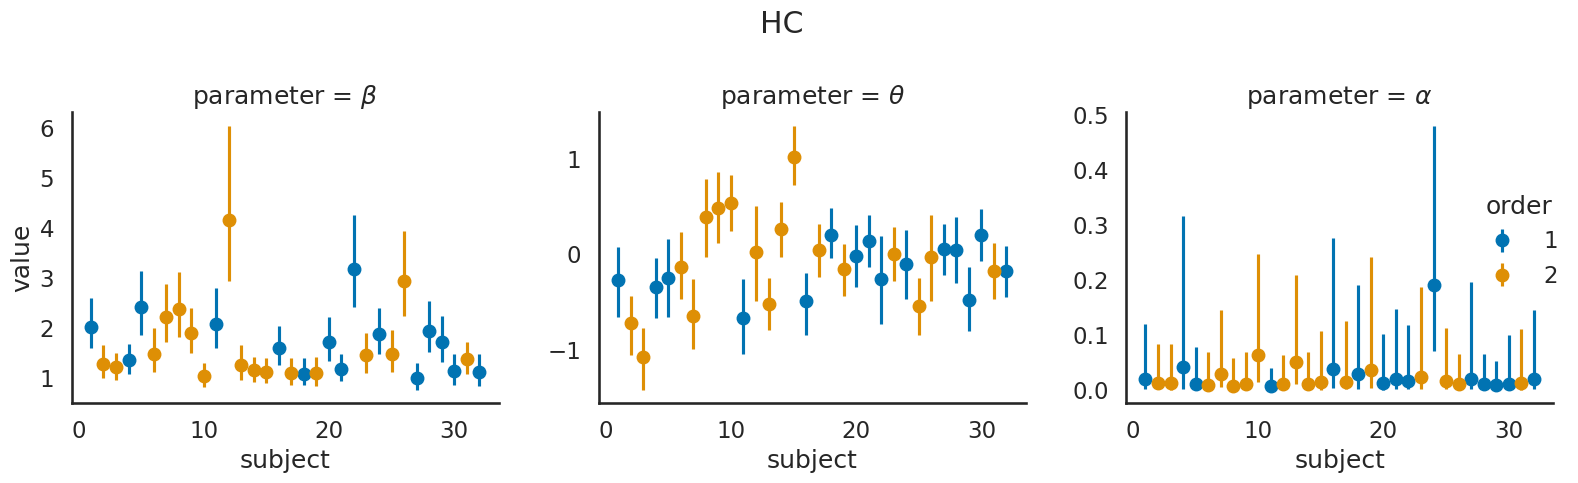

In [30]:
#%% visualize posterior parameter estimates over subjects
g = sns.FacetGrid(pars_df_aud, col="parameter", hue='order', height=5, sharey=False);
g = g.map(errorplot, 'subject', 'value').add_legend(loc='upper right');
g.fig.suptitle('AUD')
plt.tight_layout()
plt.show()
# save the figure
g.fig.savefig('post_subject_parameters_aud.pdf', dpi=300)

g = sns.FacetGrid(pars_df_hc, col="parameter", hue='order', height=5, sharey=False);
g = g.map(errorplot, 'subject', 'value').add_legend(loc='center right');
g.fig.suptitle('HC')
plt.tight_layout()
plt.show()
# save the figure
g.fig.savefig('post_subject_parameters_hc.pdf', dpi=300)

In [52]:
pars_df_mean = pars_df.groupby(by=['group','subject','parameter']).std().reset_index()

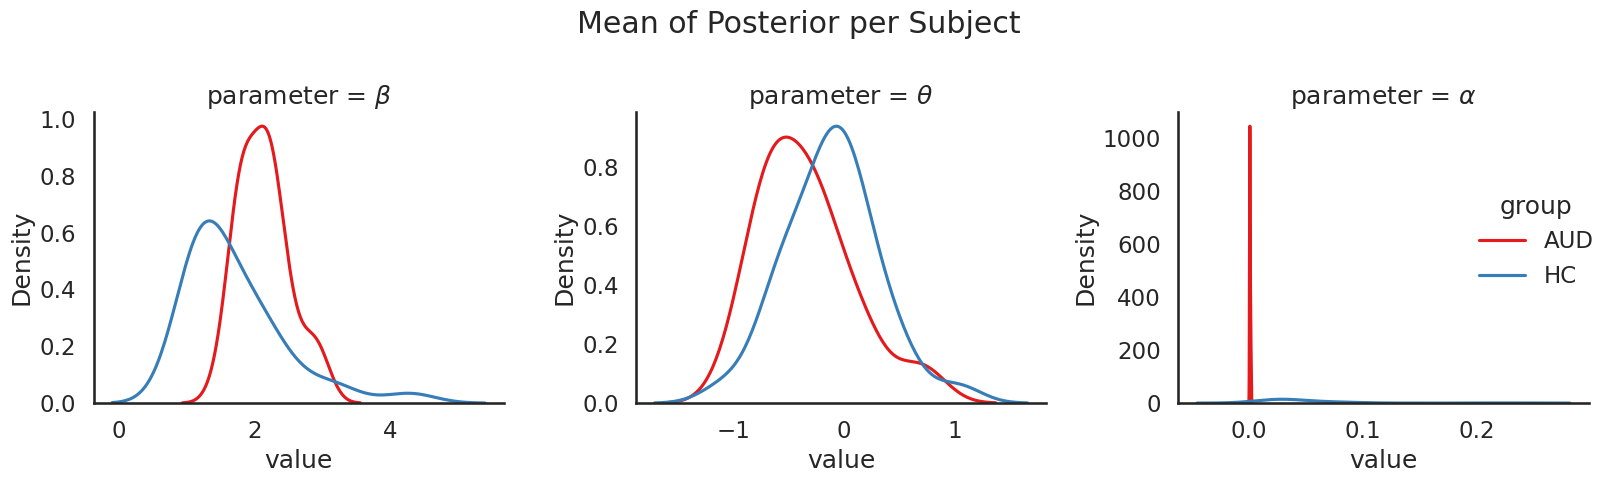

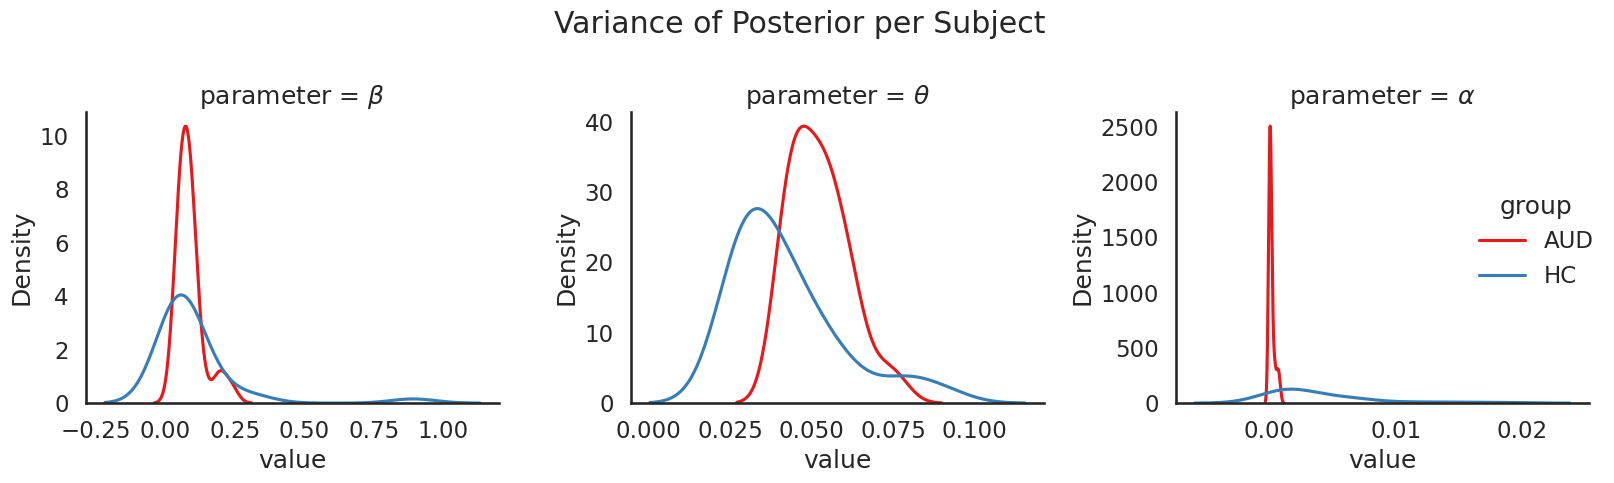

In [58]:
#%% plot posterior distribution over groups
pars_df_aud['group'] = 'AUD'
pars_df_hc['group'] = 'HC'
pars_df = pd.concat([pars_df_aud, pars_df_hc], ignore_index=True)
# store parameter posterior samples
pars_df.to_csv('pars_post_samples.csv')

# seperate variance between subject means from variance within subjects' posterior
pars_df_sbj_mean = pars_df.groupby(by=['group','subject','parameter']).mean().reset_index()
pars_df_sbj_var  = pars_df.groupby(by=['group','subject','parameter']).var().reset_index()

g = sns.FacetGrid(pars_df_sbj_mean, col="parameter", col_order=[r'$\beta$', r'$\theta$', r'$\alpha$'], hue='group', height=5, sharey=False, sharex=False, palette='Set1');
g = g.map(sns.kdeplot, 'value').add_legend();
g.fig.suptitle('Mean of Posterior per Subject')
plt.tight_layout()
plt.show()
# save the figure
g.fig.savefig('post_group_parameters_means.pdf', dpi=300)

g = sns.FacetGrid(pars_df_sbj_var, col="parameter", col_order=[r'$\beta$', r'$\theta$', r'$\alpha$'], hue='group', height=5, sharey=False, sharex=False, palette='Set1');
g = g.map(sns.kdeplot, 'value').add_legend();
g.fig.suptitle('Variance of Posterior per Subject')
plt.tight_layout()
plt.show()
# save the figure
g.fig.savefig('post_group_parameters_vars.pdf', dpi=300)

In [20]:
#%% extract and store mean posterior of planning depths
def get_posterior_stats(post_marg, mini_blocks=100):
    n_samples, runs, max_trials = post_marg['d_0_0'].shape
    post_depth = {0: np.zeros((n_samples, mini_blocks, runs, max_trials)),
              1: np.zeros((n_samples, mini_blocks, runs, max_trials))}
    for pm in post_marg:
        b, t = np.array(pm.split('_')[1:]).astype(int)
        if t in post_depth:
            post_depth[t][:, b] = post_marg[pm]

    # get sample mean over planning depth for the first and second choice
    m_prob = [post_depth[c].mean(0) for c in range(2)]

    # get sample planning depth exceedance count of the first and second choice
    # exceedance count => number of times planning depth d had highest posterior probability
    exc_count = [np.array([np.sum(post_depth[t].argmax(-1) == i, 0) for i in range(3)]) for t in range(2)]
    
    return post_depth, m_prob, exc_count

post_depth_aud, m_prob_aud, exc_count_aud = get_posterior_stats(post_marg_aud)
np.savez('plandepth_stats_aud', post_depth_aud, m_prob_aud, exc_count_aud)

post_depth_hc, m_prob_hc, exc_count_hc = get_posterior_stats(post_marg_hc)
np.savez('plandepth_stats_hc', post_depth_hc, m_prob_hc, exc_count_hc)

/tmp/ipykernel_295969/1578089241.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.stripplot(data=df_pd_mean, y="mean_pd", x="group", ax=ax[0], dodge=True, palette='Set1');
/tmp/ipykernel_295969/1578089241.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.stripplot(data=df_pd_var, y="mean_pd_var", x="group", ax=ax[1], dodge=True, palette='Set1');


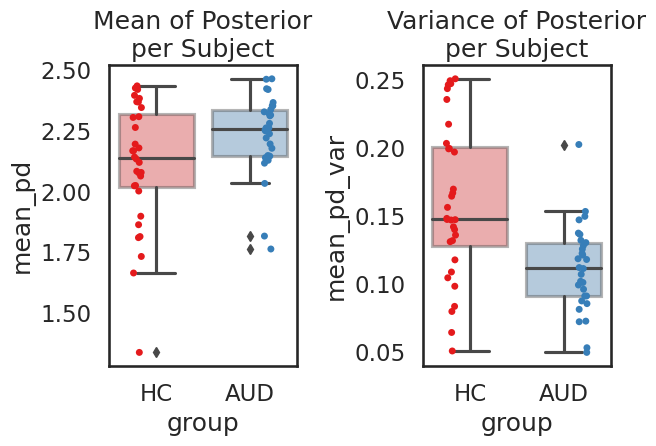

In [91]:
#%% plot planning depth posterior distribution over groups

# calc mean planning depths per subject averaged over miniblocks
df_pd_mean_hc  = pd.DataFrame({'mean_pd':np.matmul(m_prob_hc[0],  np.arange(1,4)).mean(0),'group':'HC'})
df_pd_mean_aud = pd.DataFrame({'mean_pd':np.matmul(m_prob_aud[0], np.arange(1,4)).mean(0),'group':'AUD'})
df_pd_mean = pd.concat([df_pd_mean_hc, df_pd_mean_aud], ignore_index=True)

# calc variance of mean planning depths posterior per subject and miniblock and average over miniblocks
df_pd_var_hc  = pd.DataFrame({'mean_pd_var':np.matmul(post_depth_hc[0], np.arange(1,4)).std(0).mean(0),'group':'HC'})
df_pd_var_aud = pd.DataFrame({'mean_pd_var':np.matmul(post_depth_aud[0],np.arange(1,4)).std(0).mean(0),'group':'AUD'})
df_pd_var = pd.concat([df_pd_var_hc, df_pd_var_aud], ignore_index=True)

# plot
fig, ax = plt.subplots(1,2)
g = sns.boxplot(  data=df_pd_mean, y="mean_pd", x="group", ax=ax[0], boxprops={'alpha': 0.4}, palette='Set1')
g = sns.stripplot(data=df_pd_mean, y="mean_pd", x="group", ax=ax[0], dodge=True, palette='Set1');
ax[0].set_title('Mean of Posterior\nper Subject')
g = sns.boxplot(  data=df_pd_var, y="mean_pd_var", x="group", ax=ax[1], boxprops={'alpha': 0.4}, palette='Set1')
g = sns.stripplot(data=df_pd_var, y="mean_pd_var", x="group", ax=ax[1], dodge=True, palette='Set1');
ax[1].set_title('Variance of Posterior\nper Subject')
plt.tight_layout()
plt.show()

# save the figure
fig.savefig('post_group_depth.pdf', dpi=300)